## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from utils import load_wav_to_torch

/home/richie/Desktop/projects/voice_cloning/tacotron2/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/richie/miniconda3/envs/voice_cloning/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/richie/miniconda3/envs/voice_cloning/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/richie/miniconda3/envs/voice_cloning/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/richie/miniconda3/envs/voice_cloning/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/richie/mini

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
checkpoint_path = "models/checkpoint_0"
# checkpoint_path = "models/tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'models/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/home/richie/miniconda3/envs/voice_cloning/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/richie/miniconda3/envs/voice_cloning/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/richie/miniconda3/envs/voice_cloning/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has 

#### Prepare text input

In [6]:
text = "Waveglow is really awesome!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

In [7]:
def load_speaker_model(speaker_model_path):
    from speaker.model import SpeakerEncoder
    device = torch.device("cuda")
    loss_device = torch.device("cpu")

    model = SpeakerEncoder(device, loss_device)
    speaker_dict = torch.load(speaker_model_path, map_location='cpu')
    model.load_state_dict(speaker_dict)

    # Freeze the weights of the speaker model
    for param in model.parameters():
        param.requires_grad = False

    return model
speaker_model = load_speaker_model('speaker/saved_model_e175.pt').cuda().eval().half()

In [8]:
stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length,
    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
    hparams.mel_fmax).to('cuda')

audio, sampling_rate = load_wav_to_torch('elon_musk_sample2.wav')
if sampling_rate != stft.sampling_rate:
    raise ValueError("{} SR doesn't match target {} SR".format(sampling_rate, stft.sampling_rate))

audio_norm = audio / hparams.max_wav_value
audio_norm = audio_norm.unsqueeze(0)
audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False).to('cuda')
melspec = stft.mel_spectrogram(audio_norm).transpose(1,2).half()
speaker_embedding = speaker_model(melspec)

/home/richie/miniconda3/envs/voice_cloning/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


#### Decode text input and plot results

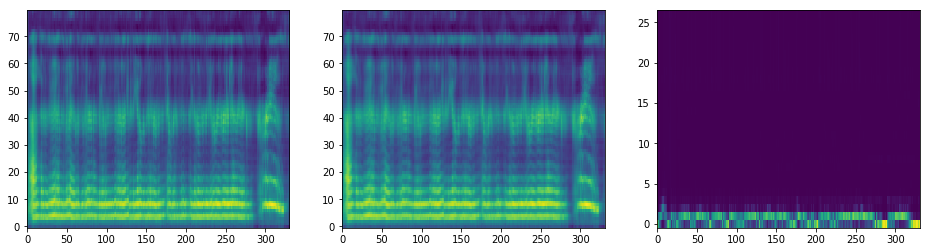

In [10]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence, speaker_embedding)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [11]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [12]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 